In [ ]:
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, savgol_filter

In [6]:
files = [
    # "/mnt/data/experiments/20260115_171408.braidz",
    "/mnt/data/experiments/20260117_125304.braidz",
]

dfs = []
stims = []

for i, file in enumerate(files):
    print(f"Loading data from {file}...")
    with zipfile.ZipFile(file, mode="r") as archive:
        with archive.open("kalman_estimates.csv.gz") as f:
            df = pd.read_csv(f, compression="gzip", comment="#")
            df["exp_num"] = i
            dfs.append(df)

        with archive.open("stim.csv") as f:
            stim = pd.read_csv(f, comment="#")
            stim["exp_num"] = i
            stims.append(stim)

df = pd.concat(dfs, ignore_index=True)
stim = pd.concat(stims, ignore_index=True)

Loading data from /mnt/data/experiments/20260117_125304.braidz...


In [57]:
angvels = []
offsets = []
responsive = []

for idx, row in stim.iterrows():
    exp_num = row["exp_num"]
    obj_id = row["obj_id"]
    frame = row["frame"]

    offset = row["stimulus_offset_deg"]

    grp = df[(df["exp_num"] == exp_num) & (df["obj_id"] == obj_id)]

    if len(grp) <= 300:
        continue

    try:
        stim_idx = np.where(grp["frame"] == frame)[0][0]
    except IndexError:
        continue

    if stim_idx - 50 < 0 or stim_idx + 100 >= len(grp):
        continue

    xvel, yvel, zvel = savgol_filter(
        grp[["xvel", "yvel", "zvel"]].to_numpy(),
        window_length=11,
        polyorder=3,
        axis=0,
    ).T

    theta = np.arctan2(yvel, xvel)
    theta_unwrap = np.unwrap(theta)
    angular_velocity = np.gradient(theta_unwrap, 0.01)

    angular_velocity = savgol_filter(
        angular_velocity,
        window_length=7,
        polyorder=2,
    )

    peaks, _ = find_peaks(np.abs(angular_velocity), height=np.deg2rad(300), distance=20)

    response_window_start = stim_idx + 20
    response_window_end = stim_idx + 60

    response_peaks = [p for p in peaks if response_window_start <= p < response_window_end]
    responsive.append(len(response_peaks) > 0)
    angvels.append(angular_velocity[stim_idx - 50 : stim_idx + 100])
    offsets.append(offset)


In [58]:
np.sum(responsive) / len(responsive)

np.float64(0.7682119205298014)

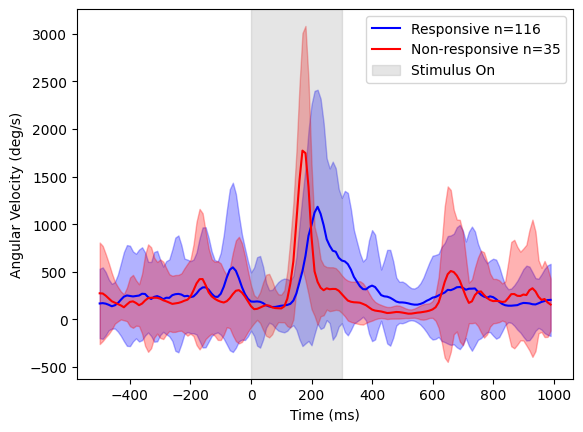

In [59]:
fig = plt.figure()

responsive_traces = np.abs(np.array(angvels)[responsive])
responsive_mean = np.rad2deg(np.mean(responsive_traces, axis=0))
responsive_std = np.rad2deg(np.std(responsive_traces, axis=0))

non_responsive_traces = np.abs(np.array(angvels)[~np.array(responsive)])
non_responsive_mean = np.rad2deg(np.mean(non_responsive_traces, axis=0))
non_responsive_std = np.rad2deg(np.std(non_responsive_traces, axis=0))

t = np.arange(-50, 100) * 10  # in ms

plt.plot(t, responsive_mean, color="blue", label=f"Responsive n={responsive_traces.shape[0]}")
plt.fill_between(
    t, responsive_mean - responsive_std, responsive_mean + responsive_std, color="blue", alpha=0.3
)

plt.plot(
    t, non_responsive_mean, color="red", label=f"Non-responsive n={non_responsive_traces.shape[0]}"
)
plt.fill_between(
    t,
    non_responsive_mean - non_responsive_std,
    non_responsive_mean + non_responsive_std,
    color="red",
    alpha=0.3,
)

plt.xlabel("Time (ms)")
plt.ylabel("Angular Velocity (deg/s)")

plt.axvspan(0, 300, color="gray", alpha=0.2, label="Stimulus On")
plt.legend()
plt.show()

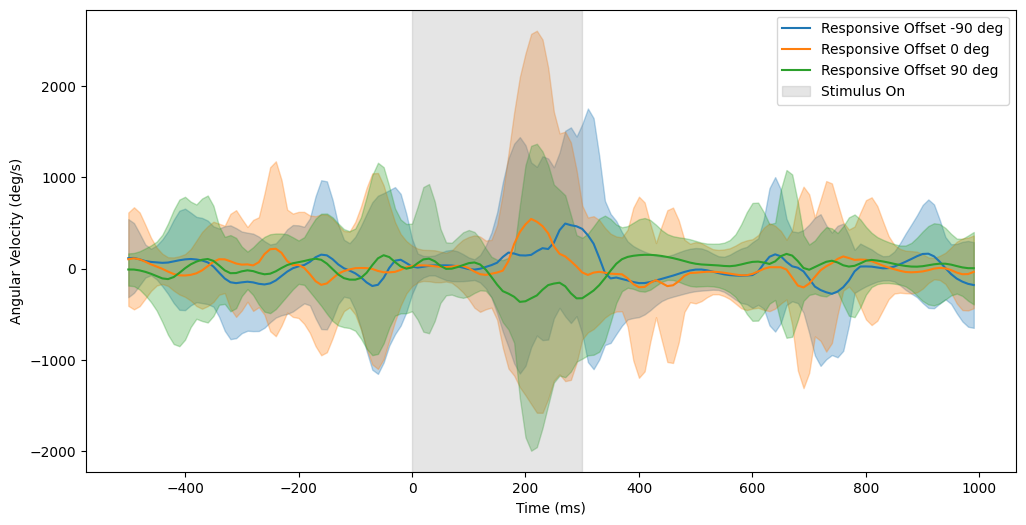

In [61]:
responsive = np.array(responsive)
angvels = np.array(angvels)
offsets = np.array(offsets)

# Generate tab20 colormap
cmap = plt.get_cmap("tab20")

# Plot raw angular velocity by offset for responsive vs non-responsive
fig, axs = plt.subplots(figsize=(12, 6))

# Loop over offsets
for i, offest in enumerate(np.sort(np.unique(offsets))):
    mask = offsets == offest

    mean_responsive = np.rad2deg(np.mean(angvels[mask & responsive], axis=0))
    std_responsive = np.rad2deg(np.std(angvels[mask & responsive], axis=0))
    t = np.arange(-50, 100) * 10  # in ms
    axs.plot(
        t,
        mean_responsive,
        label=f"Responsive Offset {offest} deg",
        c=cmap(i * 2),
    )
    axs.fill_between(
        t,
        mean_responsive - std_responsive,
        mean_responsive + std_responsive,
        color=cmap(i * 2),
        alpha=0.3,
    )

axs.set_xlabel("Time (ms)")
axs.set_ylabel("Angular Velocity (deg/s)")
axs.axvspan(0, 300, color="gray", alpha=0.2, label="Stimulus On")
axs.legend()
plt.show()
